# Overfit and Underfit

## Setup

In [111]:
# Import necessary libraries
import numpy as np
import tensorflow as tf
from IPython import display
import matplotlib.pyplot as plt

import pathlib
import shutil
import tempfile

In [112]:
!pip install git+https://github.com/tensorflow/docs

import tensorflow_docs as tfdocs
import tensorflow_docs.modeling
import tensorflow_docs.plots

  Cloning https://github.com/tensorflow/docs to /private/var/folders/np/_40hz74n2tx9zx909dmhz5380000gn/T/pip-req-build-e703sms8
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/docs /private/var/folders/np/_40hz74n2tx9zx909dmhz5380000gn/T/pip-req-build-e703sms8
  Resolved https://github.com/tensorflow/docs to commit 4e5dc6383212ee7c6bc04b0112ce70bcfddf8261
  Preparing metadata (setup.py) ... done


In [113]:
logdir = pathlib.Path(tempfile.mkdtemp()) / "tensorboard_logs"
shutil.rmtree(logdir, ignore_errors=True)

## Huggs dataset

In [114]:
gz = tf.keras.utils.get_file(
    "HIGGS.csv.gz", "http://mlphysics.ics.uci.edu/data/higgs/HIGGS.csv.gz"
)

In [115]:
FEATURES = 28

In [116]:
ds = tf.data.experimental.CsvDataset(
    gz,
    [
        float(),
    ]
    * (FEATURES + 1),
    compression_type="GZIP",
)

In [117]:
ds.__class__

tensorflow.python.data.experimental.ops.readers.CsvDatasetV2

In [118]:
def pack_row(*row):
    label = row[0]
    features = tf.stack(row[1:], 1)
    return features, label

Instead of repacking each row individually make a new tf.data.Dataset that takes batches of 10,000 examples, applies the pack_row function to each batch, and then splits the batches back up into individual records

In [119]:
packed_ds = ds.batch(10000).map(pack_row).unbatch()

tf.Tensor(
[ 0.8692932  -0.6350818   0.22569026  0.32747006 -0.6899932   0.75420225
 -0.24857314 -1.0920639   0.          1.3749921  -0.6536742   0.9303491
  1.1074361   1.1389043  -1.5781983  -1.0469854   0.          0.65792954
 -0.01045457 -0.04576717  3.1019614   1.35376     0.9795631   0.97807616
  0.92000484  0.72165745  0.98875093  0.87667835], shape=(28,), dtype=float32)


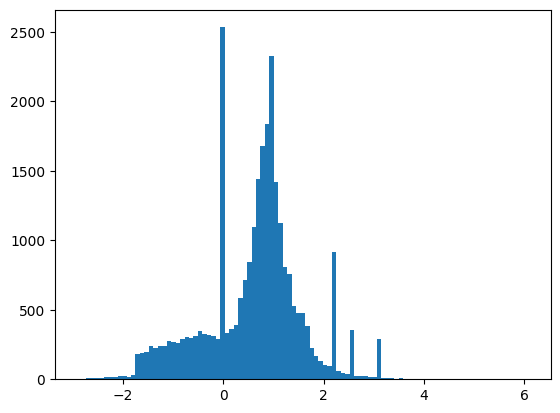

In [120]:
for features, label in packed_ds.batch(1000).take(1):
    print(features[0])
    plt.hist(features.numpy().flatten(), bins=101)

In [121]:
N_VALIDATION = int(1e3)
N_TRAIN = int(1e4)
BUFFER_SIZE = int(1e4)
BATCH_SIZE = 500
STEPS_PER_EPOCH = N_TRAIN // BATCH_SIZE

In [122]:
validate_ds = packed_ds.take(N_VALIDATION).cache()
train_ds = packed_ds.skip(N_VALIDATION).take(N_TRAIN).cache()

In [123]:
train_ds

<CacheDataset element_spec=(TensorSpec(shape=(28,), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [124]:
validate_ds = validate_ds.batch(BATCH_SIZE)
train_ds = train_ds.shuffle(BUFFER_SIZE).repeat().batch(BATCH_SIZE)

## Demonstrate overfitting

### Training procedure

In [125]:
lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
    0.001, decay_steps=STEPS_PER_EPOCH * 1000, decay_rate=1, staircase=False
)


def get_optimizer():
    return tf.keras.optimizers.Adam(lr_schedule)

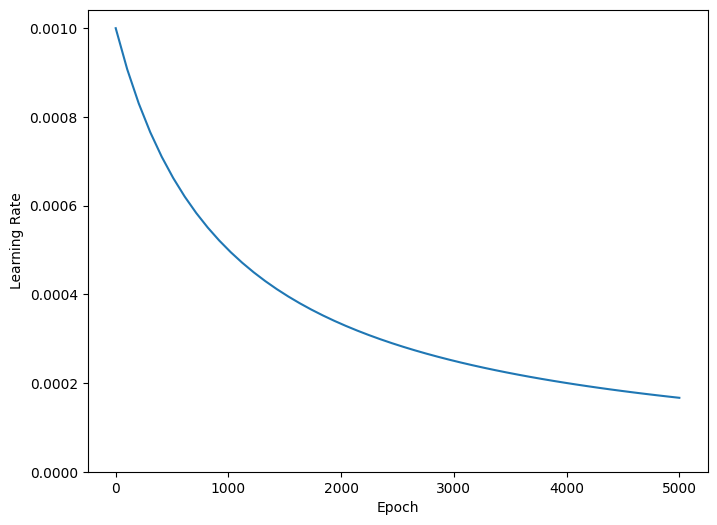

In [126]:
step = np.linspace(0, 100000)
lr = lr_schedule(step)
plt.figure(figsize=(8, 6))
plt.plot(step / STEPS_PER_EPOCH, lr)
plt.ylim([0, max(plt.ylim())])
plt.xlabel("Epoch")
_ = plt.ylabel("Learning Rate")

In [127]:
def get_callbacks(name):
    return [
        tfdocs.modeling.EpochDots(),
        tf.keras.callbacks.EarlyStopping(
            monitor="val_binary_crossentropy", patience=200
        ),
        tf.keras.callbacks.TensorBoard(logdir / name),
    ]

In [128]:
def compile_and_fit(model, name, optimizer=None, max_epochs=10000):
    if optimizer is None:
        optimizer = get_optimizer()
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
        metrics=[
            tf.keras.metrics.BinaryCrossentropy(
                from_logits=True, name="binary_crossentropy"
            ),
            "accuracy",
        ],
    )

    model.summary()

    history = model.fit(
        train_ds,
        steps_per_epoch=STEPS_PER_EPOCH,
        epochs=max_epochs,
        validation_data=validate_ds,
        callbacks=get_callbacks(name),
        verbose=0,
    )
    return history

### Tiny model

In [129]:
tiny_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(16, activation="elu", input_shape=(FEATURES,)),
        tf.keras.layers.Dense(1),
    ]
)

In [130]:
size_histories = {}

In [131]:
size_histories["Tiny"] = compile_and_fit(tiny_model, "sizes/Tiny")

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 481 (1.88 KB)

 Trainable params: 481 (1.88 KB)

 Non-trainable params: 0 (0.00 B)

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 1)

In [ ]:
for features, _ in train_ds.take(1):
    print(features.shape)

(500, 28)


/Users/isaacadoboe/miniconda3/envs/deep/lib/python3.12/site-packages/tensorflow_docs/plots/__init__.py:109: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


ValueError: max() iterable argument is empty

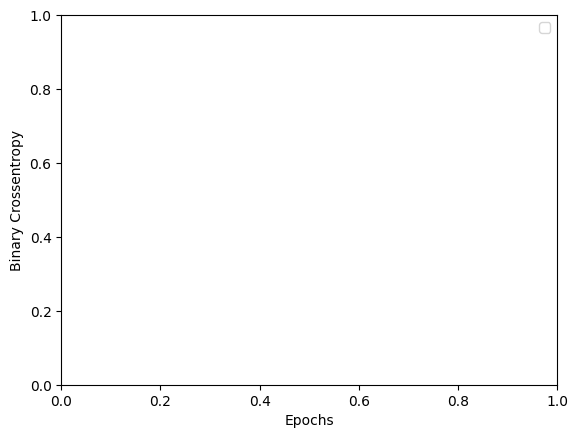

In [136]:
plotter = tfdocs.plots.HistoryPlotter(metric = 'binary_crossentropy', smoothing_std=10)
plotter.plot(size_histories)
plt.ylim([0.5, 0.7])

### Small model

In [ ]:
small_model = tf.keras.Sequential(
    [
        # `input_shape` is only required here so that `.summary` works.
        tf.keras.layers.Dense(16, activation="elu", input_shape=(FEATURES,)),
        tf.keras.layers.Dense(16, activation="elu"),
        tf.keras.layers.Dense(1),
    ]
)


size_histories["Small"] = compile_and_fit(small_model, "sizes/Small")

/Users/isaacadoboe/miniconda3/envs/deep/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                │ (None, 16)             │           464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 753 (2.94 KB)

 Trainable params: 753 (2.94 KB)

 Non-trainable params: 0 (0.00 B)

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 1)

### Medium model

In [ ]:
medium_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(64, activation="elu", input_shape=(FEATURES,)),
        tf.keras.layers.Dense(64, activation="elu"),
        tf.keras.layers.Dense(64, activation="elu"),
        tf.keras.layers.Dense(1),
    ]
)

size_histories["Medium"] = compile_and_fit(medium_model, "sizes/Medium")

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_15 (Dense)                │ (None, 64)             │         1,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,241 (40.00 KB)

 Trainable params: 10,241 (40.00 KB)

 Non-trainable params: 0 (0.00 B)

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 1)

### Large model

In [134]:
large_model = tf.keras.Sequential(
    [
        tf.keras.layers.Dense(512, activation="elu", input_shape=(FEATURES,)),
        tf.keras.layers.Dense(512, activation="elu"),
        tf.keras.layers.Dense(512, activation="elu"),
        tf.keras.layers.Dense(512, activation="elu"),
        tf.keras.layers.Dense(1),
    ]
)

size_histories["large"] = compile_and_fit(large_model, "sizes/large")

/Users/isaacadoboe/miniconda3/envs/deep/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_19 (Dense)                │ (None, 512)            │        14,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_20 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_21 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_22 (Dense)                │ (None, 512)            │       262,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_23 (Dense)                │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 803,329 (3.06 MB)

 Trainable params: 803,329 (3.06 MB)

 Non-trainable params: 0 (0.00 B)

ValueError: Arguments `target` and `output` must have the same rank (ndim). Received: target.shape=(None,), output.shape=(None, 1)

### Plot the training and validation losses

In [135]:
plotter.plot(size_histories)
a = plt.xscale('log')
plt.xlim([5, max(plt.xlim())])
plt.ylim([0.5, 0.7])
plt.xlabel("Epochs [Log Scale]")

NameError: name 'plotter' is not defined